In [1]:
import pandas as pd
import numpy as np
from pandas import read_excel
from pandas import DataFrame
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import day_abbr, month_abbr, mdays
import datetime
#from datetime import datetime
#from fbprophet import Prophet
#from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

#Author: Vatsala

In [2]:
plot_file_path="../plotImages/"

In [3]:
# Choose a specific date
specific_date = 25

# Read Data
#Note: Data has been QC-ed

In [4]:
#read Plot 1 data
data = read_excel('../plotData/plotData_1.xlsx', sheet_name='Sheet1', index_col=13, parse_dates=[13])    

In [5]:
print(data.head(10))
data.dtypes

                     QC  Plot_ID  DailyRep treatment       Date   pv      ghg  \
DateTime                                                                        
2019-03-26 17:26:00   0        1         4        F0 2019-03-26  ***  N2O_dry   
2019-03-26 21:49:00   0        1         5        F0 2019-03-26  ***  N2O_dry   
2019-03-27 06:28:00   0        1         1        F0 2019-03-27  ***  N2O_dry   
2019-03-28 20:34:00   0        1         2        F0 2019-03-28    *  N2O_dry   
2019-03-30 02:43:00   0        1         0        F0 2019-03-30  ***  N2O_dry   
2019-03-30 15:27:00   0        1         2        F0 2019-03-30  ***  N2O_dry   
2019-03-30 19:51:00   0        1         3        F0 2019-03-30   **  N2O_dry   
2019-03-31 00:17:00   0        1         0        F0 2019-03-31  ***  N2O_dry   
2019-03-31 04:43:00   0        1         1        F0 2019-03-31  ***  N2O_dry   
2019-03-31 13:32:00   0        1         3        F0 2019-03-31  ***  N2O_dry   

                    unit   

QC                     int64
Plot_ID                int64
DailyRep               int64
treatment             object
Date          datetime64[ns]
pv                    object
ghg                   object
unit                  object
flux                 float64
r2                   float64
nrmse                float64
podpu                float64
epoch_time            object
dtype: object

In [6]:
#This dataframe will be used for running in the Prophet model
#Extract only datetime and flux from the series
dataframe = DataFrame()
#dataframe['DateTime'] = data['DateTime']
dataframe['Flux']     = data['flux']
dataframe['ghg']      = data['ghg']
print(dataframe.tail(10))

                          Flux      ghg
DateTime                               
2019-06-27 22:38:00   768.2786  CO2_dry
2019-06-28 02:56:00   550.3863  CO2_dry
2019-06-28 15:51:00   351.4631  CO2_dry
2019-06-28 20:09:00   867.6166  CO2_dry
2019-06-29 00:27:00  1160.3080  CO2_dry
2019-06-29 04:46:00   930.5471  CO2_dry
2019-06-29 13:22:00   412.6364  CO2_dry
2019-06-29 17:41:00   540.0715  CO2_dry
2019-06-29 21:59:00   953.3316  CO2_dry
2019-06-30 02:17:00   684.4827  CO2_dry


### Feature Engineering

In [7]:
#create some time series features to see how the trends are impacted by day of week, hour, time of year, etc.
def create_features(df, label=None):
    #convert the datetime object to string - for plotting purposes

    '''Create time series features from date time index'''
    df = df.copy()
    df['date']        = df.index
    df['dateS']       = df['date'].apply(lambda x: x.strftime("%d/%m/%Y %(%H:%M)"))  #used for plotting purposes
    df['hour']        = df['date'].dt.hour
    df['dayofmonth']  = df['date'].dt.day
    df['weekdayname'] = df['date'].dt.weekday_name
    df['month']       = df['date'].dt.month
    df['year']        = df['date'].dt.year
    df['weekofyear']  = df['date'].dt.weekofyear
    
   # if df['ghg'] != None:
    #    df['ghg']         = df['ghg']
    X = df[['date', 'dateS', 'year', 'month', 'dayofmonth', 'weekdayname', 'weekofyear', 'hour', 'ghg']]  #features should be a matrix
    #else:
    #     X = df[['date', 'year', 'month', 'dayofmonth', 'weekdayname', 'weekofyear', 'hour']]  #features should be a matrix
       
    if label:
        y = df[label]   #target
        return X,y
    return X

In [11]:
X, y = create_features(dataframe, 'Flux')    #the target is the flux in this case; the features = X (as shown above)
features_target = pd.concat([X, y], axis=1)  #concatenate the features and the target
features_target.to_csv('out.csv', index=True)
features_target

,date,dateS,year,month,dayofmonth,weekdayname,weekofyear,hour,ghg,Flux
DateTime,,,,,,,,,,
2019-03-26 17:26:00,2019-03-26 17:26:00,26/03/2019 (17:26),2019,3,26,Tuesday,13,17,N2O_dry,-144.0262
2019-03-26 21:49:00,2019-03-26 21:49:00,26/03/2019 (21:49),2019,3,26,Tuesday,13,21,N2O_dry,-102.3469
2019-03-27 06:28:00,2019-03-27 06:28:00,27/03/2019 (06:28),2019,3,27,Wednesday,13,6,N2O_dry,-93.0909
2019-03-28 20:34:00,2019-03-28 20:34:00,28/03/2019 (20:34),2019,3,28,Thursday,13,20,N2O_dry,63.8219
2019-03-30 02:43:00,2019-03-30 02:43:00,30/03/2019 (02:43),2019,3,30,Saturday,13,2,N2O_dry,-157.9453
...,...,...,...,...,...,...,...,...,...,...
2019-06-29 04:46:00,2019-06-29 04:46:00,29/06/2019 (04:46),2019,6,29,Saturday,26,4,CO2_dry,930.5471
2019-06-29 13:22:00,2019-06-29 13:22:00,29/06/2019 (13:22),2019,6,29,Saturday,26,13,CO2_dry,412.6364
2019-06-29 17:41:00,2019-06-29 17:41:00,29/06/2019 (17:41),2019,6,29,Saturday,26,17,CO2_dry,540.0715


### Pick up a particular day of month for further analysis for that particular day of month
e.g Day 25 shows the largest range of flux values 

In [13]:
#Pick up a particular date for extensive viewing of the results
# e.g. day of month to pick up = 25
dataframe_specificDates = features_target[features_target['dayofmonth'] == specific_date]
#drop column date
dataframe_specificDates = dataframe_specificDates.drop('date', axis=1)   #delete the column without having to reassign features_target
#print(dataframe_specificDates)
dataframe_specificDates

#N2O_dry, CH4_dry, CO2_dry
dataframe_N2Odry = dataframe_specificDates[dataframe_specificDates['ghg'] == "N2O_dry"]
#dataframe_N2Odry
dataframe_CH4dry = dataframe_specificDates[dataframe_specificDates['ghg'] == "CH4_dry"]
#dataframe_CH4dry
dataframe_CO2dry = dataframe_specificDates[dataframe_specificDates['ghg'] == "CO2_dry"]
dataframe_CO2dry

,dateS,year,month,dayofmonth,weekdayname,weekofyear,hour,ghg,Flux
DateTime,,,,,,,,,
2019-04-25 02:14:00,25/04/2019 (02:14),2019,4,25,Thursday,17,2,CO2_dry,680.3637
2019-04-25 10:51:00,25/04/2019 (10:51),2019,4,25,Thursday,17,10,CO2_dry,-558.4424
2019-04-25 19:35:00,25/04/2019 (19:35),2019,4,25,Thursday,17,19,CO2_dry,948.4666
2019-04-25 23:53:00,25/04/2019 (23:53),2019,4,25,Thursday,17,23,CO2_dry,1024.4490
2019-05-25 00:29:00,25/05/2019 (00:29),2019,5,25,Saturday,21,0,CO2_dry,1085.1450
2019-05-25 22:02:00,25/05/2019 (22:02),2019,5,25,Saturday,21,22,CO2_dry,630.8297
2019-06-25 01:45:00,25/06/2019 (01:45),2019,6,25,Tuesday,26,1,CO2_dry,1267.5850
2019-06-25 06:03:00,25/06/2019 (06:03),2019,6,25,Tuesday,26,6,CO2_dry,982.9480
2019-06-25 10:22:00,25/06/2019 (10:22),2019,6,25,Tuesday,26,10,CO2_dry,872.3429


### Plot the results - for the specific day of month here

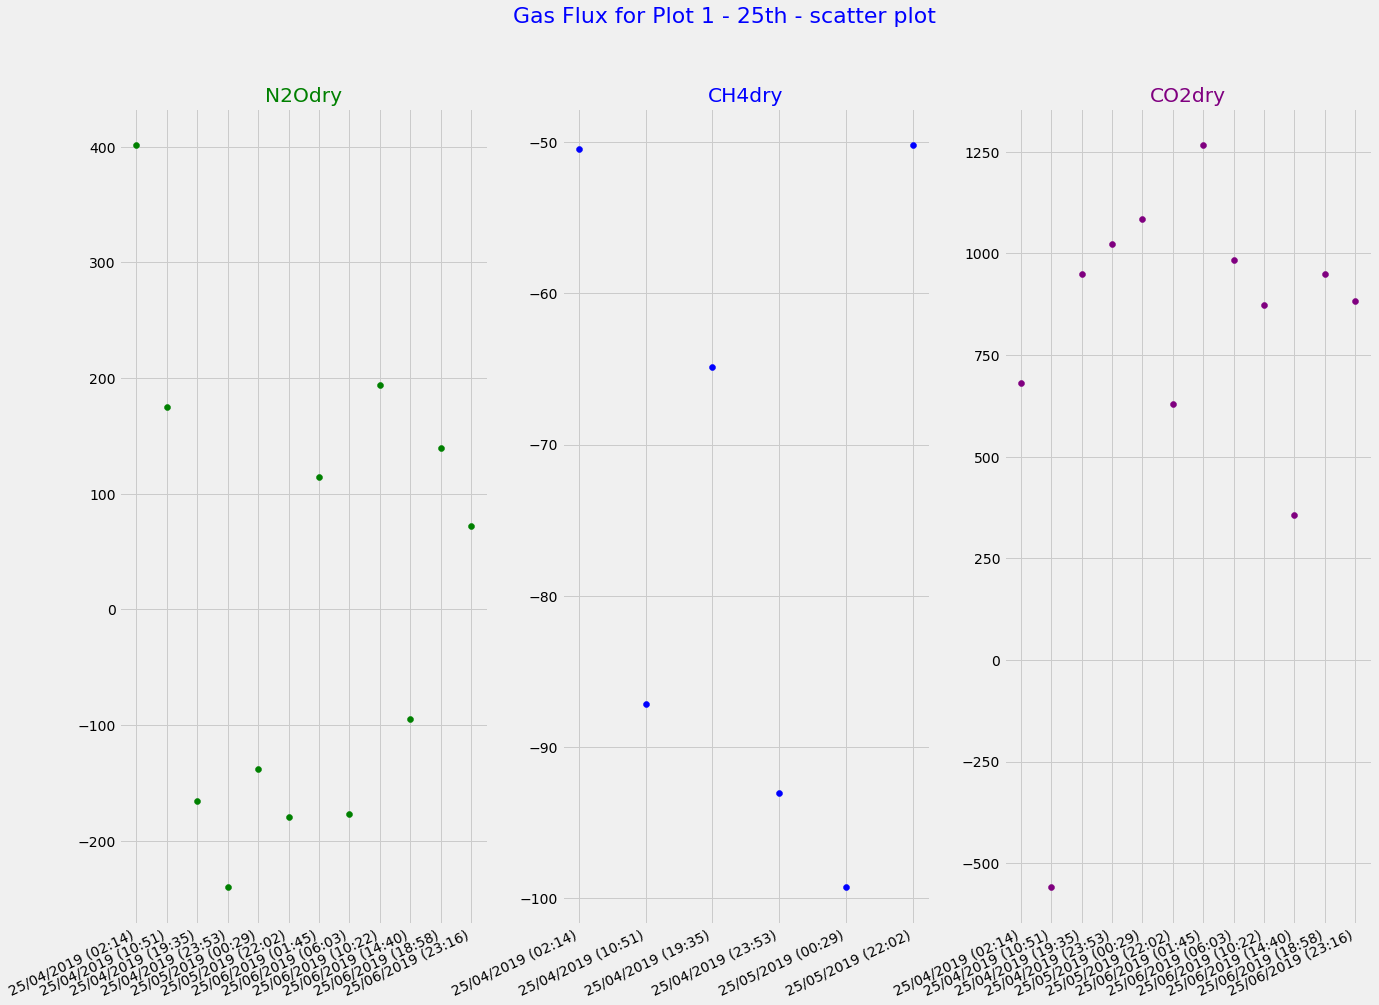

In [18]:
#2. plot the different data frames
#fig,ax = plt.subplots()
plt.figure(figsize=(25,14))
plt.suptitle('Gas Flux for Plot 1 - '+str(specific_date)+'th - scatter plot', color='blue', size=22)

plt.subplot(131)
plt.xticks(rotation=25, ha='right')
plt.title('N2Odry', color='green')
plt.scatter(dataframe_N2Odry['dateS'], dataframe_N2Odry['Flux'], color='green')

plt.subplot(132)
plt.xticks(rotation=25, ha='right')
plt.title('CH4dry', color='blue')
plt.scatter(dataframe_CH4dry['dateS'], dataframe_CH4dry['Flux'], color='blue')

plt.subplot(133)
plt.xticks(rotation=25, ha='right')
plt.title('CO2dry', color='purple')
plt.scatter(dataframe_CO2dry['dateS'], dataframe_CO2dry['Flux'], color='purple')

#plt.xlabel(dataframe_specificDates['date'], rotation = 45, ha="right")
#ax.set_xticklabels(dataframe_specificDates['date'], rotation = 45) 

#Save boxplot as a file
#output file name
output_file_name = "Plot1/gasflux_Plot1_scatterplot_3Gases.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

plt.show()

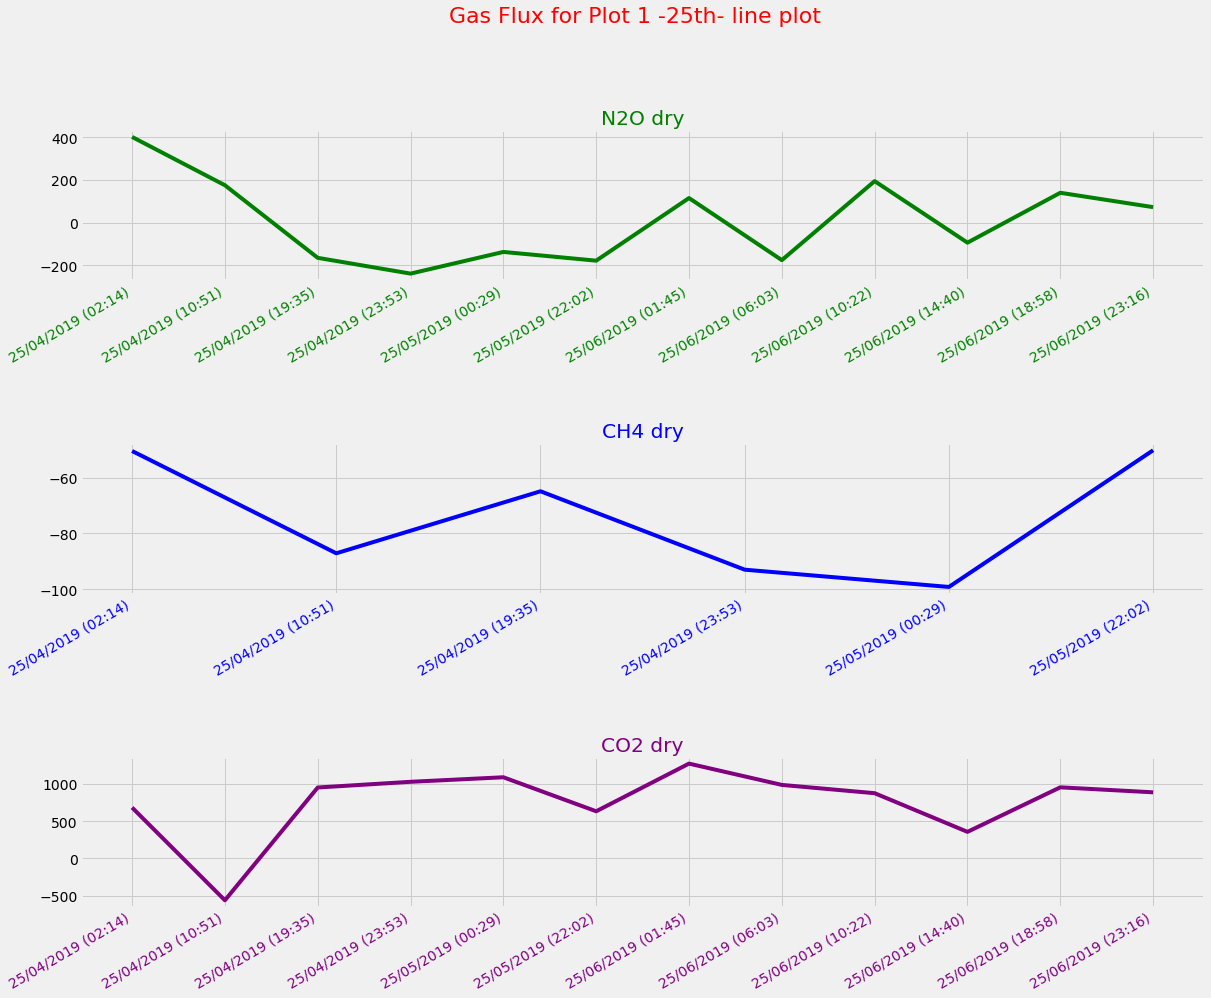

In [19]:
#Plot the figures VERTICALLY

plt.rcParams["figure.figsize"] = (20, 15)
fig, axs = plt.subplots(3)
fig.suptitle('Gas Flux for Plot 1 -'+str(specific_date)+'th- line plot', color='red', size=22)
fig.tight_layout(pad=10.0)

#plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.2)
#plt.xticks(rotation=30, ha='right', color = 'purple')     #- Note: this code will work only for the last chart

axs[0].plot(dataframe_N2Odry['dateS'], dataframe_N2Odry['Flux'], color = 'green')  #, edgecolor = 'darkblue'
axs[0].set_title('N2O dry', color = 'green')
axs[0].set_xticklabels(dataframe_N2Odry['dateS'], rotation=30, ha='right', color = 'green')

axs[1].plot(dataframe_CH4dry['dateS'], dataframe_CH4dry['Flux'],  color = 'blue')
axs[1].set_title('CH4 dry', color = 'blue')
axs[1].set_xticklabels(dataframe_CH4dry['dateS'], rotation=30, ha='right', color = 'blue')

axs[2].plot(dataframe_CO2dry['dateS'], dataframe_CO2dry['Flux'],  color = 'purple')
axs[2].set_title('CO2 dry', color = 'purple')
axs[2].set_xticklabels(dataframe_CO2dry['dateS'], rotation=30, ha='right', color = 'purple')

#Save boxplot as a file
#output file name
output_file_name = "Plot1/gasflux_Plot1_lineplot_3Gases_dayofmonth.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

plt.show()

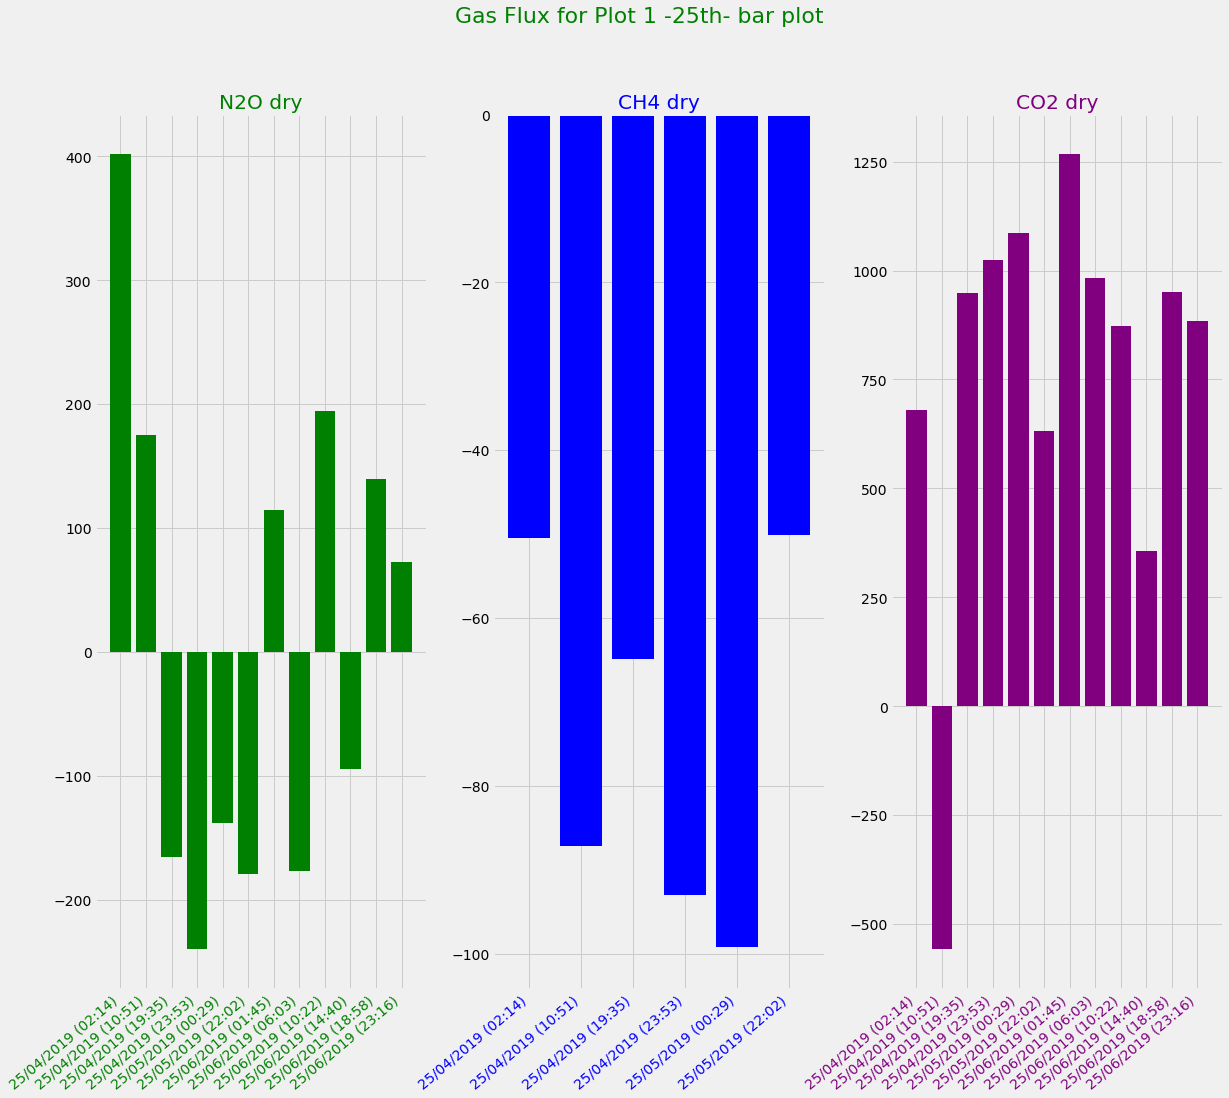

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 15))
fig.suptitle('Gas Flux for Plot 1 -'+str(specific_date)+'th- bar plot', color='green', size=22)

plt.xticks(rotation=30, ha='right')   #This is for the last drawing (ax3)

ax1.bar(dataframe_N2Odry['dateS'], dataframe_N2Odry['Flux'], color='green')
ax1.set_xticklabels(dataframe_N2Odry['dateS'], rotation=40, ha='right', color='green')
ax1.set_title('N2O dry', color = 'green')

ax2.bar(dataframe_CH4dry['dateS'], dataframe_CH4dry['Flux'], color='blue')
#ax2.set_ylim(None, None)
ax2.set_xticklabels(dataframe_CH4dry['dateS'], rotation=40, ha='right', color='blue')
ax2.set_title('CH4 dry', color = 'blue')

ax3.bar(dataframe_CO2dry['dateS'], dataframe_CO2dry['Flux'], color='purple')
#for rotated x labels, please refer to line at the beginning - used plt.xticks (to remove text showing up)
ax3.set_xticklabels(dataframe_CO2dry['dateS'], rotation=40, ha='right', color='purple')
ax3.set_title('CO2 dry', color = 'purple')


#Save boxplot as a file
#output file name
output_file_name = "Plot1/gasflux_Plot1_barplot_3Gases_dayofmonth.png" 
plot_file_name = plot_file_path + output_file_name

# save as png
#plt.tight_layout()
plt.savefig(plot_file_name, dpi=50, bbox_inches='tight')

plt.show()
